**Climate Corporation Assignment – Intern ML/Analytics**

Selected Problem Statement : 

2. Predict the movement for Indian stocks using the data provided by National Stock
Exchange (NSE). The data sets are available publicly, use the same to build a machine
![](http://)learning model.

### Approach :

1. Explore the data
2. Feature Engieering/ Sampling etc
3. Understading the time series data - basic idea about trend and seasonality using decomposing.
4. Based on the presence of seasonality or trend , or both list down relevant models.
5. Fit the models with the processed data
6. Evaluate the models with performance metrics.
7. Choose the best model available for predictions.
8. Conclusion/Summary.

**Basis of Models Selection :**

1. Stationary Data : Simple average models,Simple Exponential models AR etc
2. Data with trend : ETS, Double Exponetial Smoothing, regression models , ARIMA models
3. Data with trend and seasonality : SARIMA, Triple Exponential Smoothing etc


*Apart from the above listed models, we will also be using Deep Learning Models with RNN-LSTM , Facebook Prophet etc**

In [105]:
import numpy as np 
import pandas as pd 
import itertools
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error




import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 11.7,8.27

In [106]:
df=pd.read_excel('/kaggle/input/nifty-50/Nifty_11to20.xlsx')

Data Selected for Time Series Forecasting - Nifty 50 Index from 2011.

In [4]:
df.describe()

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
count,2365.000000,2365.000000,2365.000000,2365.000000,2.365000e+03,2365.000000
mean,8151.381882,8192.848478,8096.149345,8144.314503,2.446868e+08,10656.332947
std,2219.231143,2223.321558,2208.479064,2215.474632,1.815555e+08,7031.024600
min,4623.150000,4623.150000,4531.150000,4544.200000,6.555703e+06,297.890000
25%,5901.300000,5928.650000,5867.800000,5904.100000,1.429929e+08,6218.340000
50%,8173.100000,8213.600000,8123.450000,8170.800000,1.815397e+08,8186.240000
75%,10215.350000,10270.850000,10139.200000,10210.850000,2.616075e+08,12709.440000
max,12430.500000,12430.500000,12321.400000,12362.300000,1.811564e+09,59705.530000


In [5]:
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,2011-01-03,6177.45,6178.55,6147.20,6157.60,96028639,4477.36
1,2011-01-04,6172.75,6181.05,6124.40,6146.35,181727905,7678.55
2,2011-01-05,6141.35,6141.35,6062.35,6079.80,139614193,6606.21
3,2011-01-06,6107.00,6116.15,6022.30,6048.25,152338978,7050.18
4,2011-01-07,6030.90,6051.20,5883.60,5904.60,171809106,8325.79


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2365 non-null   datetime64[ns]
 1   Open               2365 non-null   float64       
 2   High               2365 non-null   float64       
 3   Low                2365 non-null   float64       
 4   Close              2365 non-null   float64       
 5   Shares Traded      2365 non-null   int64         
 6   Turnover (Rs. Cr)  2365 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 129.5 KB


In [107]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [108]:
df.index

DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06',
               '2011-01-07', '2011-01-10', '2011-01-11', '2011-01-12',
               '2011-01-13', '2011-01-14',
               ...
               '2020-07-09', '2020-07-10', '2020-07-13', '2020-07-14',
               '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-20',
               '2020-07-21', '2020-07-22'],
              dtype='datetime64[ns]', name='Date', length=2365, freq=None)

In [109]:
x=pd.infer_freq(df.index)
print(x)

None


Inferred freq is 'None', Several dates may be missing due to holidays etc

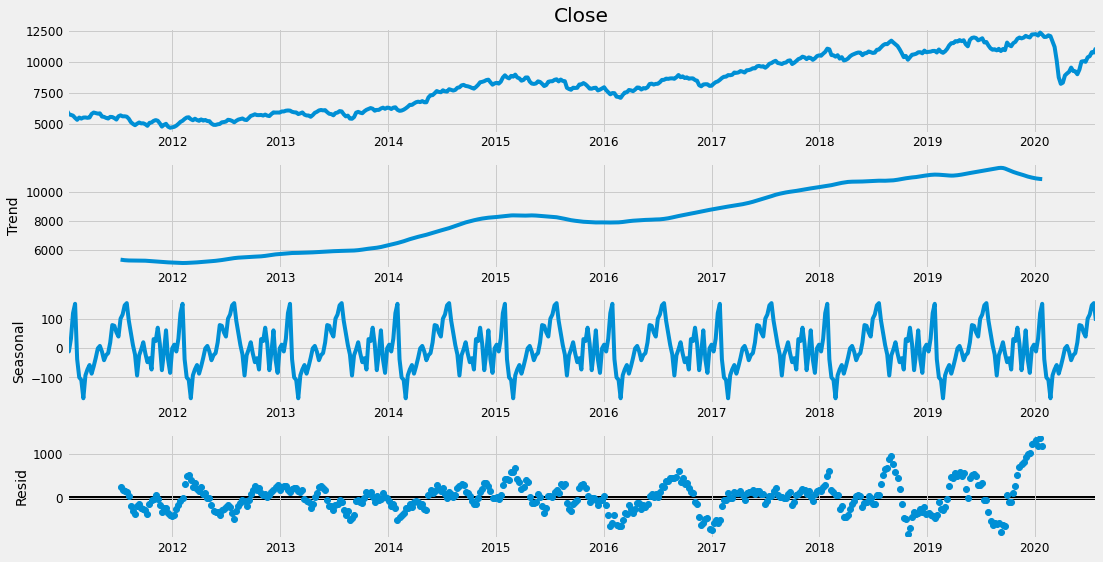

In [110]:
# Lets Check the trend and seasonality of the data by decomposing, 
# before that ,in order to decompose we need freq, since the inferred frequency is none, freq has to be explicitely mentioned
# I will be doing downsampling to weekly frequency with mean values of closing stock prices.

from statsmodels.tsa.seasonal import seasonal_decompose
df1 = df['Close'].resample('W').mean()
season = seasonal_decompose(df1)
graph = season.plot();
graph.set_size_inches(16,8)

From the above decompsition we can observe that the there is both Trend (upward) and Seasonality (yearly) associated with the data. There we need to choose a model which can forecast considering both trend and seasonality.

Models that can be used are :
1. SARIMA
2. Triple Exponential Smoothing
3. Deep Learning [LSTM].
4. Facebook Prophet. 

*Note : I will be using only one feature with time Stamp, i.e. Closing values of stock price index ['Close'].*

## 1. SARIMA-Model

Since the data has yealry seasonality and data is available on daily basis, the SARIMA model may not perform well while building model with Seasonal Period as 365. Therefore I will be downsampling the data to weekly basis.

In [111]:
weekly_df = df.Close.resample('W').mean()

In [112]:
weekly_df.head()

Date
2011-01-09    6067.320
2011-01-16    5757.330
2011-01-23    5695.590
2011-01-30    5636.775
2011-02-06    5455.520
Freq: W-SUN, Name: Close, dtype: float64

In [113]:
len(weekly_df)

499

In [114]:
import plotly.express as px

In [115]:
fig = px.line(weekly_df)
fig.show()

We can observe from the above interactive plot, i.e. from March 2020 , there is drastic fall in the index value due to unforeseen circumstance of Corona Virus Pandemic and it is very difficult to predict during these times, 
therefore for the study and assignment purpose I Will be considering data before March 2020

In [116]:
time_series_weekly=weekly_df[:'29-02-2020']

In [118]:
len(time_series_weekly)

477

#### Splitting data into train and test

In [119]:
training_factor = 0.8
train_size_sarima = int(time_series_weekly.shape[0]*training_factor)
train_sarima =  time_series_weekly[0:train_size_sarima]
test_sarima =  time_series_weekly[train_size_sarima:]
print('Training Size is {} and Tesing size is {}.'.format(len(train_sarima),len(test_sarima)))

Training Size is 381 and Tesing size is 96.


#### Approach for SARIMA

SARIMA Model requires 7 factors, i.e p(AR), d(differencing), q(MA) factors, another set of P,D,Q for seasonal components and a Seasonal period component 'm'.

Approach 1 : AR(p/P) and MA(q/Q) terms to be found out using PACF and ACF plots respectively, and d values is found by differencing until a stationalry time series is obtained.

Approach 2 : AR,MA and D terms are found using a type of grid search method.

I will be trying both the approaches.

### SARIMA --Approach 1

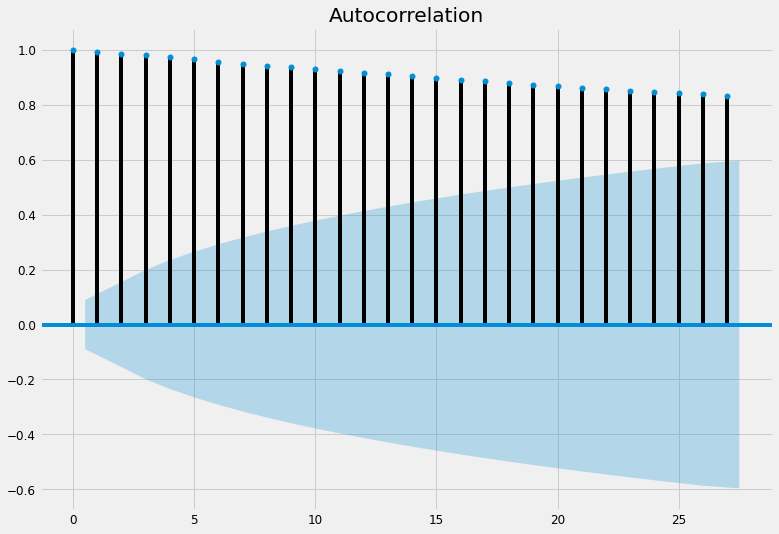

In [120]:
plot_acf(time_series_weekly);

We can see from the avove ACF plot, that there is gradual decay with respect to correlations value suggesting that data is not stationary.

That data should be stationary to find the right , AR and MA terms.

We can use adfuller test and also rolling mean, stdev to check the stationarity of the data.

Lets Create a function to check the stationarity.

In [121]:
#Function to check stationarity

def test_stationarity(timeseries):
    #Determining rolling statistics
    rolmean=timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(12,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    X = timeseries.dropna().values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

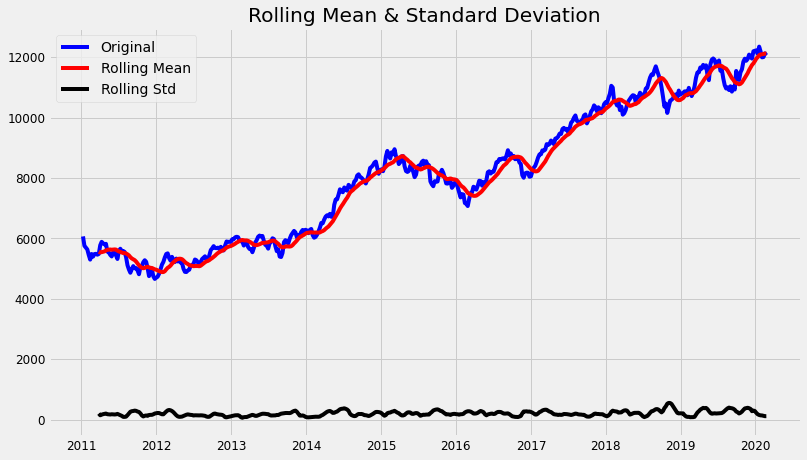

Results of Dickey-Fuller Test:
ADF Statistic: -0.086150
p-value: 0.950801
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [122]:
test_stationarity(time_series_weekly)

We can observe the rolling mean and the critical value of adfuller test, both suggest that the data is not stationary.

Lets difference the data and check for stationarity.

In [123]:
first_diff=(time_series_weekly-time_series_weekly.shift(1)).dropna()

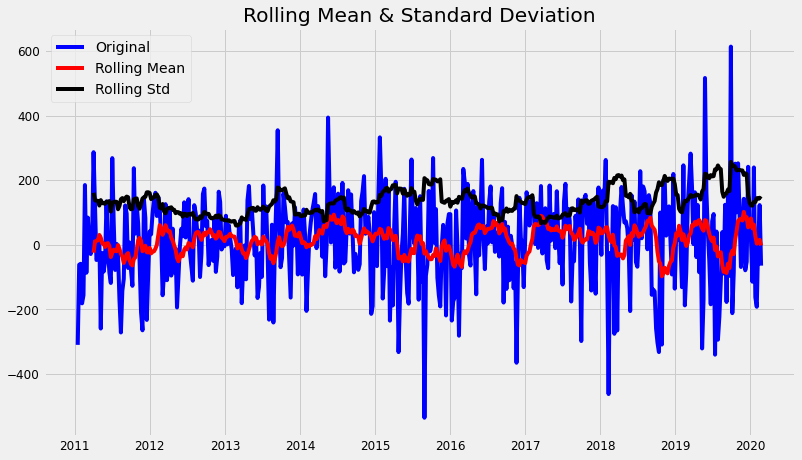

Results of Dickey-Fuller Test:
ADF Statistic: -19.557030
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [124]:
test_stationarity(first_diff)

The first difference data looks stationary from adfuller and rolling stats.

We can also plot ACF and PACF and confirm the same.

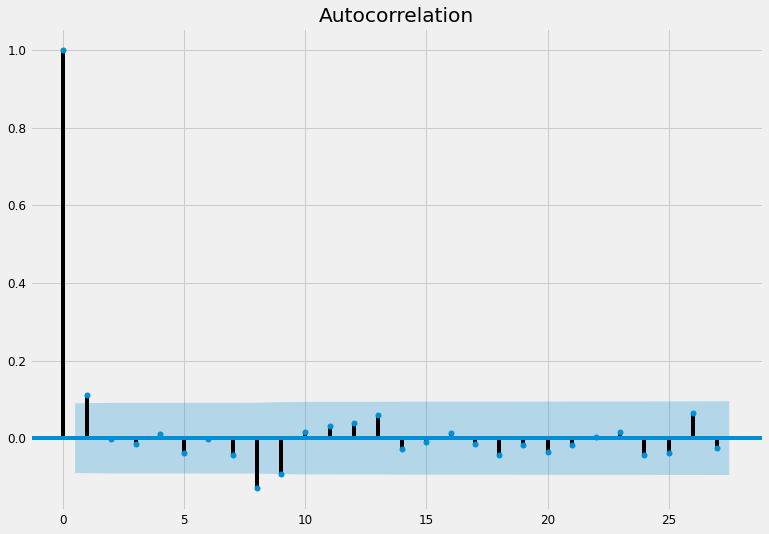

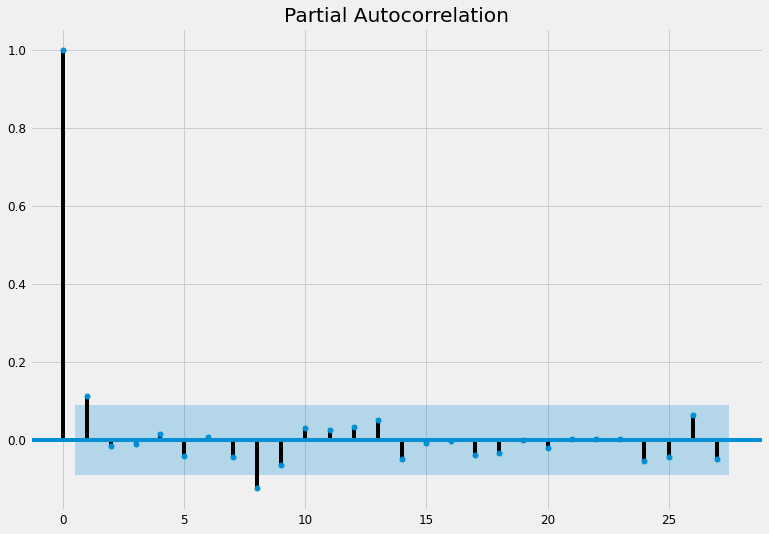

In [125]:
plot_acf(first_diff);
plot_pacf(first_diff);

The sharp cut off in the ACF suggests the stationarity of the data.

The PACF suggest AR-1 (p->1) since the significant, r value is present only at the first lag and ACF suggest MA(1) q->1.

and d=1 for first difference.

Since there is seasonality in the data, We need to find the P,D,Q for Seasonal components of the time series. m will be 53 since the no weeks are approx 53 in a year.

In [126]:
first_seasonal_diff=(first_diff-first_diff.shift(53)).dropna()
first_seasonal_diff.head()

Date
2012-01-22    452.680
2012-01-29    223.090
2012-02-05    148.265
2012-02-12    329.435
2012-02-19    269.050
Freq: W-SUN, Name: Close, dtype: float64

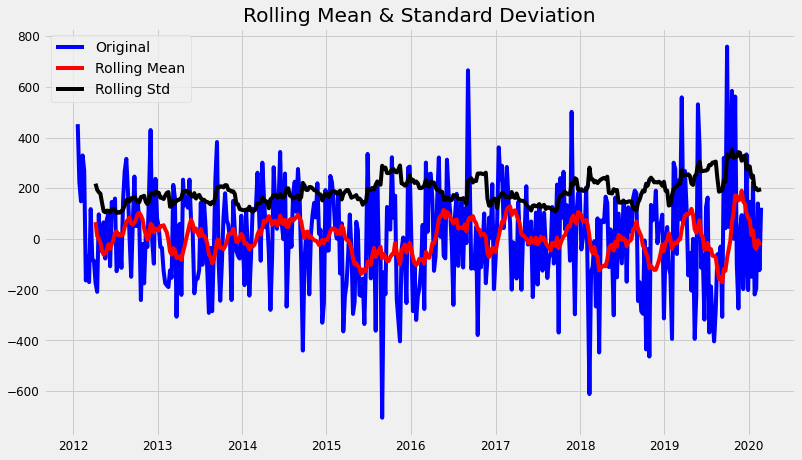

Results of Dickey-Fuller Test:
ADF Statistic: -8.510763
p-value: 0.000000
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.570


In [127]:
#Check stationarity of the first seasonal difference
test_stationarity(first_seasonal_diff)

Adfuller test and Rolling Stats confirm the first seasonal difference is stationary. 
D in SARIMA will be 1

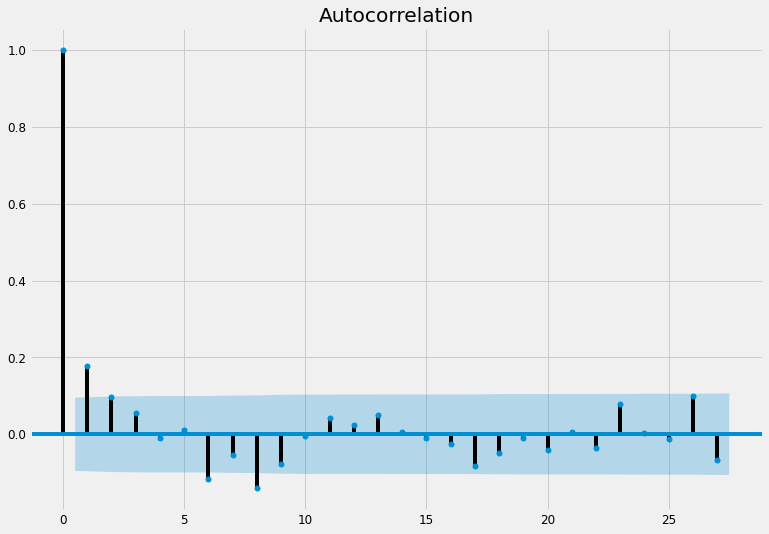

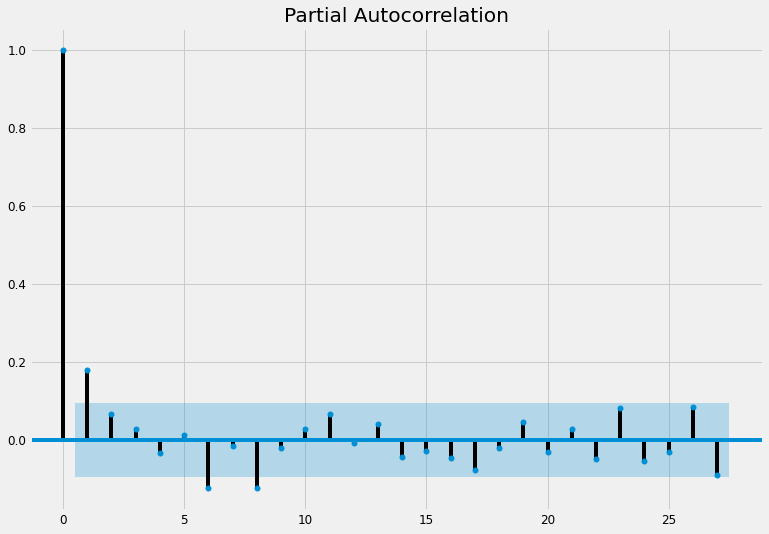

In [128]:
plot_acf(first_seasonal_diff.dropna());
plot_pacf(first_seasonal_diff.dropna());

The ACF suggest the presence of MA(2), Q-> 2 term and PACF suggest AR(1) P-> 1

SARIMA(p,d,q)(P,D,Q)m --> SARIMA(1,1,1)(1,1,2)53

### SARIMA --Approach 2

In [129]:
# Now let us find the best parameters by manualling looping over the possible values of p,d,q and choosing based on 
# - AIC of the models.

In [ ]:
c=0
dic_1={}
dic_2={}
print('Iteration Starts:\n')

p = q = range(1, 3)
d=range(1,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 53) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_sarima,order=param,seasonal_order=param_seasonal)

            results = mod.fit()
            c=c+1
            forecast=results.forecast(len(test_sarima))
            mse = ((forecast - test_sarima) ** 2).mean()
            rmse_sarima=round(np.sqrt(mse), 2)
            print('SARIMA{}x{} - RMSE:{}, AIC:{} '.format(param, param_seasonal, rmse_sarima, round(results.aic,2)))
        except:
            continue
        a=str(param)+'x'+str(param_seasonal)
        dic_1[a]=rmse_sarima.round(2)
        dic_2[a]=round(results.aic,2)
        #dic_1[a]=results.aic.round(2)

print('\n **********Iteration End**********')
print('\n Total Models Built:',c)
min_val_key=min(dic_2.keys(), key=(lambda k: dic_2[k]))
print('\n The Best Model is--> ', min_val_key, 'with AIC value of ', dic_2[min_val_key])

We can observe that the AIC values of all the models are very near to one another.

There is no significant difference between the AIC of the best model above and the AIC of the SARMIMA(1,1,1)(1,1,2,53) which was selected manually by observing ACF and PACF plots. 

Therefore we will stick with parameters SARMIMA(1,1,1)(1,1,2,53) selected manually and go ahead with building the model.

**Model Building**

In [130]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

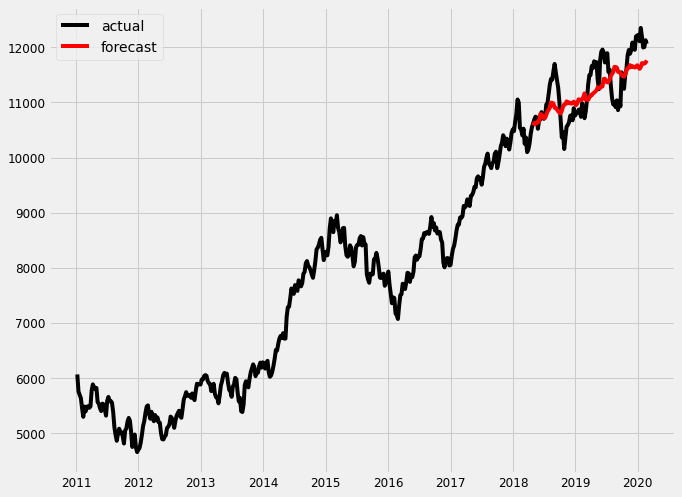

In [131]:
model = SARIMAX(train_sarima, order=(1,1,1), seasonal_order=(1,1,2,53))
model_fit=model.fit()
pred=model_fit.forecast(len(test_sarima))
plt.figure(figsize=(10,8))
plt.plot(time_series_weekly,color='black',label='actual')
plt.plot(pred,color='red',label='forecast')
plt.legend(loc="upper left")

In [132]:
#RMSE
mse = ((pred - test_sarima) ** 2).mean()
rmse_SARIMA=round(np.sqrt(mse), 2)
print('The Mean Squared Error of forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of forecasts is {}'.format(rmse_SARIMA))

The Mean Squared Error of forecasts is 157630.61
The Root Mean Squared Error of forecasts is 397.03


## Deep Learning LSTM

In [134]:
time_series_DL=df.Close[:'29-02-2020']

In [135]:
len(time_series_DL)

2269

In [136]:
training_factor = 0.95
train_size_DL = int(time_series_DL.shape[0]*training_factor)
train_DL =  time_series_DL[0:train_size_DL]
test_DL =  time_series_DL[train_size_DL:]
print('Training Size is {} and Tesing size is {}.'.format(len(train_DL),len(test_DL)))

Training Size is 2155 and Tesing size is 114.


In [137]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [138]:
scaler.fit(train_DL.values.reshape(-1,1))
scaled_train = scaler.transform(train_DL.values.reshape(-1,1))
scaled_test = scaler.transform(test_DL.values.reshape(-1,1))

In [139]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [140]:
n_lag = 30
n_features=1

train_data_gen = TimeseriesGenerator(scaled_train, scaled_train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(scaled_train, scaled_train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(scaled_test, scaled_test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, GRU

In [142]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [144]:
model_LSTM=Sequential()
model_LSTM.add(LSTM(512,input_shape=(n_lag, n_features),return_sequences=True))
model_LSTM.add(Dropout(0.2))
#model_LSTM.add(BatchNormalization())

model_LSTM.add(LSTM(256,return_sequences=True))
model_LSTM.add(Dropout(0.2))
#model_LSTM.add(BatchNormalization())

model_LSTM.add(LSTM(256,return_sequences=True))
model_LSTM.add(Dropout(0.2))
#model_LSTM.add(BatchNormalization())

model_LSTM.add(LSTM(128,return_sequences=False))
model_LSTM.add(Dropout(0.2))
#model_LSTM.add(BatchNormalization())

model_LSTM.add(Dense(32,activation='relu'))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1))

model_LSTM.compile(optimizer='adam', loss='mse')

In [145]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 30, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)              

In [146]:
checkpointer = ModelCheckpoint(filepath='stacked_lstm_weights.hdf5'
                               , verbose=1
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss',
                             patience=10,
                             verbose=1)
with open("stacked_lstm.json", "w") as m:
    m.write(model_LSTM.to_json())

stacked_lstm = model_LSTM.fit_generator(train_data_gen
                                                , epochs=20
                                                , validation_data=valid_data_gen
                                                , verbose=1
                                                , callbacks=[checkpointer, earlystopper])

Epoch 1/20
422/425 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 00001: val_loss improved from inf to 0.00226, saving model to stacked_lstm_weights.hdf5
425/425 [==============================] - 17s 40ms/step - loss: 0.0219 - val_loss: 0.0023
Epoch 2/20
424/425 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00002: val_loss did not improve from 0.00226
425/425 [==============================] - 16s 37ms/step - loss: 0.0079 - val_loss: 0.0162
Epoch 3/20
424/425 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 00003: val_loss did not improve from 0.00226
425/425 [==============================] - 16s 37ms/step - loss: 0.0076 - val_loss: 0.0025
Epoch 4/20
423/425 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 00004: val_loss improved from 0.00226 to 0.00165, saving model to stacked_lstm_weights.hdf5
425/425 [==============================] - 15s 36ms/step - loss: 0.0068 - val_loss: 0.0016
Epoch 5/20
422/425 [==============

Text(0.5, 1.0, 'Loss VS Epoch')

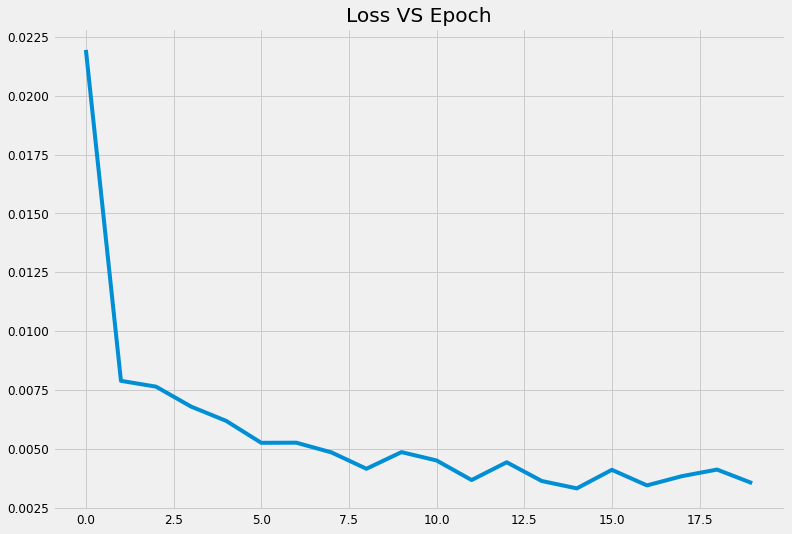

In [147]:
loss_per_epoch = model_LSTM.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss VS Epoch')

In [148]:
from keras.models import model_from_json

json_file = open('stacked_lstm.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("stacked_lstm_weights.hdf5")
print("Loaded model from disk")

Loaded model from disk


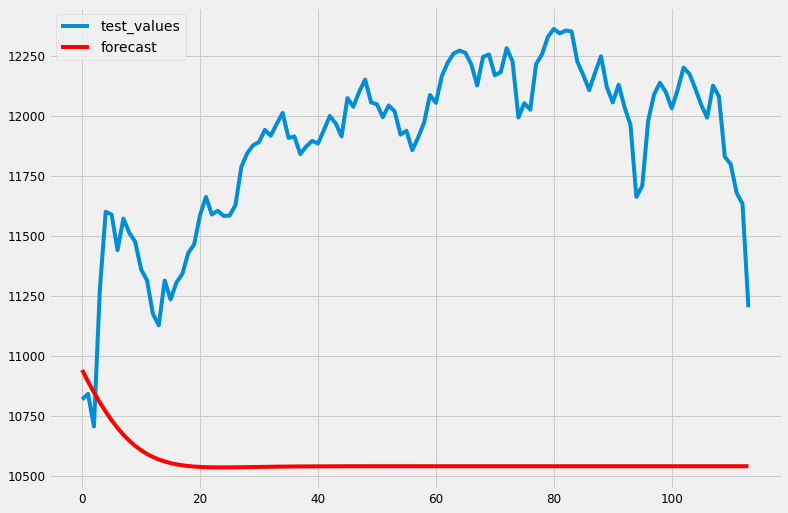

In [151]:
## Predictions without Walk forward validation

test_predictions = []

first_eval_batch = scaled_train[-n_lag:]
current_batch = first_eval_batch.reshape((1, n_lag, n_features))

for i in range(len(test_DL)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = loaded_model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
true_predictions = scaler.inverse_transform(test_predictions)
plt.plot(test_DL.values,label='test_values')
plt.plot(true_predictions,color='red',label='forecast')
plt.legend(loc='upper left')

We can see that model performance is not upto the mark. 

Lets try the same LSTM model built with **Walk forward validation**

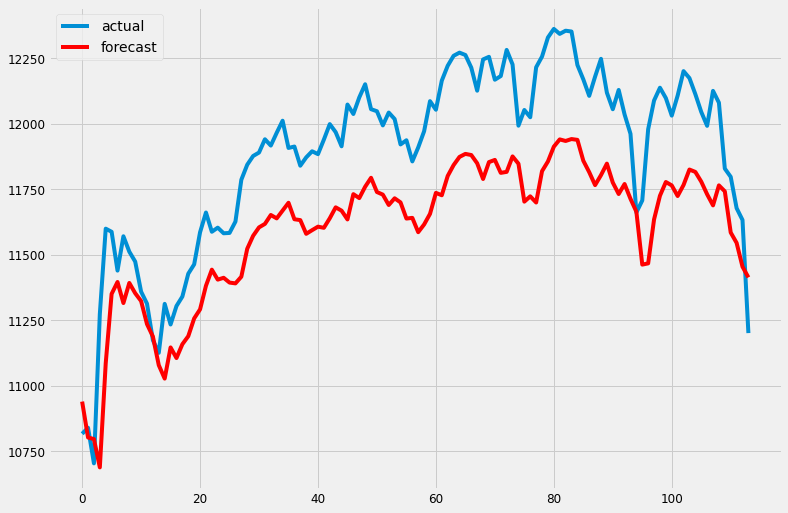

In [154]:
## Walk forward Validation

test_predictions = []

first_eval_batch = scaled_train[-n_lag:]
current_batch = first_eval_batch.reshape((1, n_lag, n_features))

for i in range(len(test_DL)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = loaded_model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[[scaled_test[i][0]]]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
plt.plot(test_DL.values,label='actual')
plt.plot(true_predictions,color='red',label='forecast')
plt.legend(loc='upper left')

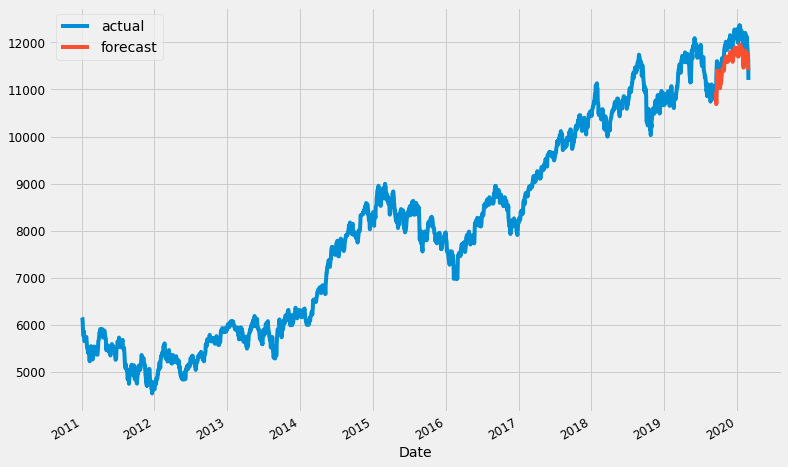

In [155]:
time_series_DL_pred=(pd.DataFrame(test_DL)).copy()
time_series_DL_pred['pred']=true_predictions

time_series_DL.plot(label='actual')
time_series_DL_pred['pred'].plot(label='forecast')
plt.legend(loc="upper left")

We can see that LSTM with walk forward validation performs much better with respect to future predictions than the general model

In [156]:
#RMSE (with walk forward validation)
mse = ((time_series_DL_pred['pred'] - time_series_DL_pred['Close']) ** 2).mean()
rmse_DL=round(np.sqrt(mse), 2)
print('The Mean Squared Error of forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of forecasts is {}'.format(rmse_DL))

The Mean Squared Error of forecasts is 100061.62
The Root Mean Squared Error of forecasts is 316.33


## Triple Exponential Smoothing - Holts Winter Method

In [157]:
# We will again use Weekly aggregated data , since seasonal period with 365 is not practical for modelling

from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [158]:
training_factor_ets = 0.8
train_size_ets = int(time_series_weekly.shape[0]*training_factor_ets)
train_ets =  time_series_weekly[0:train_size_ets]
test_ets =  time_series_weekly[train_size_ets:]
print('Training Size is {} and Tesing size is {}.'.format(len(train_ets),len(test_ets)))

Training Size is 381 and Tesing size is 96.


In [159]:
dic={}
print('Iteration Starts:\n')
i = 53 # seasonal period
for j in ['add','mul']:
    for k in ['add','mul']:
        model_ets = ExponentialSmoothing(train_ets,trend=j,seasonal=k,seasonal_periods=i).fit()
        forecast_e=model_ets.forecast(len(test_ets))
        mse = ((forecast_e - test_ets) ** 2).mean()
        rmse_ets=round(np.sqrt(mse), 2)
        print('Value of AIC with trend:',j,',sesonality:',k, 'and seasonal period:',i,\
        'is',model_ets.aic.round(2), 'and RMSE is',rmse_ets)
        a='Trend: '+j+' Seasonality: '+k+' with seasonal period: '+str(i)
        dic[a]=model_ets.aic.round(2)
        
print('\n **********Iteration End**********')
min_val_key=min(dic.keys(), key=(lambda k: dic[k]))
print('\n The Best Model is--> ', min_val_key, 'with Akaike information criterion value of ', dic[min_val_key])

Iteration Starts:

Value of AIC with trend: add ,sesonality: add and seasonal period: 53 is 4000.9 and RMSE is 706.44
Value of AIC with trend: add ,sesonality: mul and seasonal period: 53 is 4040.99 and RMSE is 1965.37
Value of AIC with trend: mul ,sesonality: add and seasonal period: 53 is nan and RMSE is nan
Value of AIC with trend: mul ,sesonality: mul and seasonal period: 53 is 4111.86 and RMSE is 1336.78

 **********Iteration End**********

 The Best Model is-->  Trend: add Seasonality: add with seasonal period: 53 with Akaike information criterion value of  4000.9


The Mean Squared Error of our forecasts is 499054.1
The Root Mean Squared Error of our forecasts is 706.44


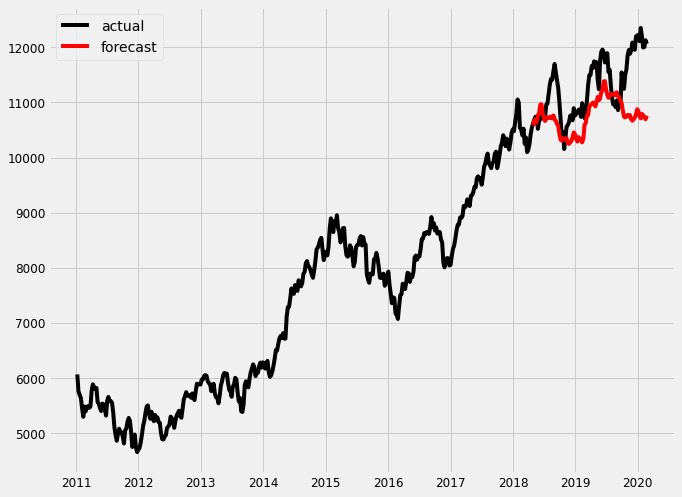

In [160]:
model_ets = ExponentialSmoothing(train_ets,trend='add',seasonal='add',seasonal_periods=53).fit()
forecast_ets=model_ets.forecast(len(test_ets))
mse = ((forecast_ets - test_ets) ** 2).mean()
rmse_ets=round(np.sqrt(mse), 2)

plt.figure(figsize=(10,8))
plt.plot(time_series_weekly,color='black',label='actual')
plt.plot(forecast_ets,color='red',label='forecast')
plt.legend(loc="upper left")

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(rmse_ets))

The performance of ETS model is also satisfactory, RMSE of 706 is much higher compared to previous models

## Facebook Prophet

In [13]:
from fbprophet import Prophet

In [14]:
df_fb=pd.read_excel('/kaggle/input/nifty-50/Nifty_11to20.xlsx')

In [16]:
df_fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2365 non-null   datetime64[ns]
 1   Open               2365 non-null   float64       
 2   High               2365 non-null   float64       
 3   Low                2365 non-null   float64       
 4   Close              2365 non-null   float64       
 5   Shares Traded      2365 non-null   int64         
 6   Turnover (Rs. Cr)  2365 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 129.5 KB


In [29]:
time_series_fb=df_fb[df_fb['Date']<='29-02-2020']

In [30]:
time_series_fb=time_series_fb[['Date','Close']]
time_series_fb.rename(columns={'Date':'ds','Close':'y'},inplace=True)

In [31]:
time_series_fb.head()

,ds,y
0,2011-01-03,6157.60
1,2011-01-04,6146.35
2,2011-01-05,6079.80
3,2011-01-06,6048.25
4,2011-01-07,5904.60


In [32]:
training_factor = 0.95
train_size_fb = int(time_series_fb.shape[0]*training_factor)
train_fb =  time_series_fb[0:train_size_fb]
test_fb =  time_series_fb[train_size_fb:]
print('Training Size is {} and Tesing size is {}.'.format(len(train_fb),len(test_fb)))

Training Size is 2155 and Tesing size is 114.


In [47]:
model_fb=Prophet()
model_fb.fit(train_fb)

In [69]:
forecast_fb_prim = model_fb.make_future_dataframe(periods=len(test_fb))
forecast_fb_prim = model_fb.predict(forecast_fb_prim)
forecast_fb=forecast_fb_prim[['yhat']]
forecast_fb['Date']=test_fb['ds']
forecast_fb.set_index('Date',inplace=True)

In [97]:
forecast_fb_prim = model_fb.make_future_dataframe(periods=len(test_fb))
forecast_fb_prim = model_fb.predict(forecast_fb_prim)
forecast_fb=forecast_fb_prim[['yhat']]
forecast_fb['Date']=time_series_fb['ds']
forecast_fb.set_index('Date',inplace=True)

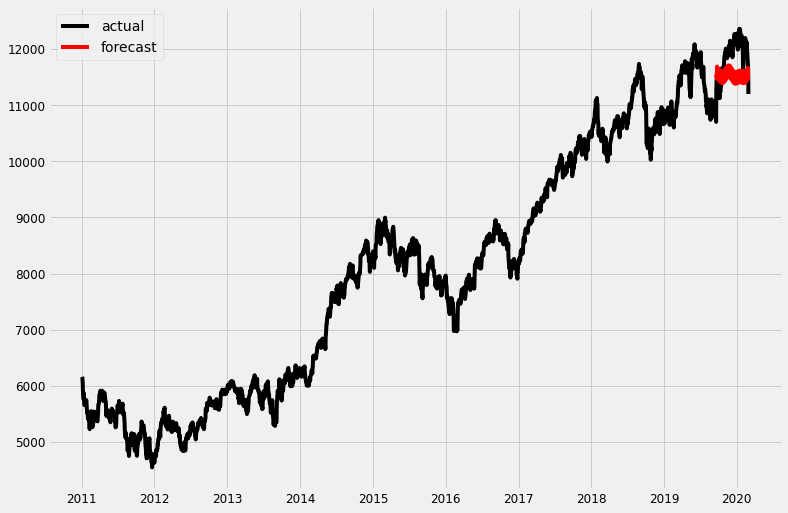

In [85]:
plt.plot(time_series_fb.set_index('ds'),color='black',label='actual')
plt.plot(forecast_fb.tail(len(test_fb)),color='red',label='forecast')
plt.legend(loc="upper left")

In [104]:
mse = ((test_fb['y'].values - forecast_fb.tail(len(test_fb['y'])).values) ** 2).mean()
rmse_fb=round(np.sqrt(mse), 2)

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(rmse_fb))

The Mean Squared Error of our forecasts is 296720.09
The Root Mean Squared Error of our forecasts is 544.72


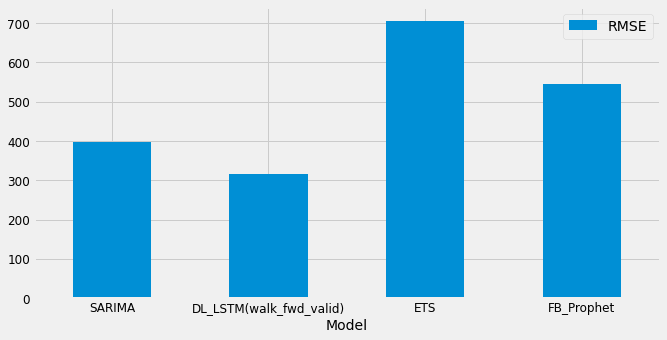

In [170]:
df = pd.DataFrame({'Model':['SARIMA', 'DL_LSTM(walk_fwd_valid)', 'ETS', 'FB_Prophet'], 'RMSE':[rmse_SARIMA, rmse_DL, rmse_ets, rmse_fb]})
ax = df.plot.bar(x='Model', y='RMSE', rot=0,figsize=(15,5))

For Short term forecasting, LSTM with walk forward validation provides best results, where as for long term movement prediction SARIMA model can be used.
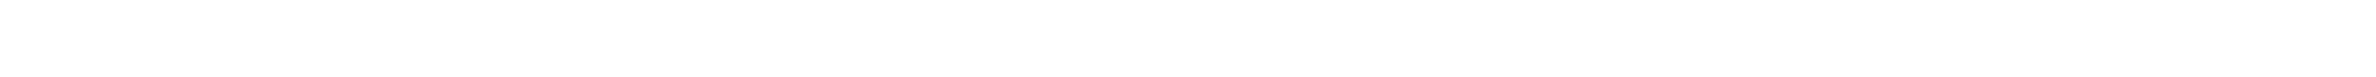